# Project: The Floofiest Floofer

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#gather">Gather</a></li>
<li><a href="#assess">Assess</a></li>
<li><a href="#clean">Clean</a></li> 
<li><a href="#analysis">Analysis</a></li>
<ul>
<li><a href="#rttime">Retweets over Time</a></li>
<li><a href="#rtbreed">Retweets versus Dog Breed</a></li>
<li><a href="#rtstage">Retweets versus Dog Stage</a></li>
</ul>

<a id='intro'></a>
## Introduction

> In this project, we will try to uncover interesting trends from WeRateDogs, a twitter page where people upload photos of the loves of their lives (their dogs) and rate them far above the maximum limit. We ignore this fallacy because *no one* can resist a good floofer.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tweepy
import json
import requests
import os

<a id='wrangling'></a>
## Data Wrangling
>Before doing any analyses, we have to go through the steps of gathering, assesing, and cleaning our data. While these steps can be quite energy-intensive, performing any sort of analyis without data wrangling would be a nightmare. At least wrangling can be a nightmare you intentionally choose to put yourself through.

<a id='gather'></a>
## Gather

- A .csv: `twitter-archive-enhanced.csv` with WeRateDogs tweet information, such as the tweet's text
- JSON info using Tweepy and Twitter's API to create a `tweet_json.txt` file to obtain information such as number of retweets
- A .tsv: `image-predictions.tsv` with predications for the breed of dog posted with each WeRateDogs tweet

### Obtain the twitter-archive-enhanced.csv

In [3]:
weRateDogs = pd.read_csv('twitter-archive-enhanced.csv')
weRateDogs.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


Column definitions from the Twitter API webpage: 

**in_reply_to_status_id**: 
>Nullable. If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID.

**in_reply_to_user_id**: 
>Nullable. If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID. This will not necessarily always be the user directly mentioned in the Tweet.

**retweeted_status_id** and **retweeted_status_user_id**
>This attribute contains a representation of the original Tweet that was retweeted. Note that retweets of retweets do not show representations of the intermediary retweet, but only the original Tweet.

### Obtain the image-predictions.tsv file

We need to pull this file programmatically from le internet.

To do this, we use `Requests`

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(url)

In [5]:
with open('tweet_json3.txt', 'wb') as file:
    file.write(response.content)

In [6]:
imagePredict = pd.read_csv('tweet_json3.txt', sep = '\t')
imagePredict.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
689,684188786104872960,https://pbs.twimg.com/media/CX66EiJWkAAVjA-.jpg,1,kelpie,0.537782,True,American_Staffordshire_terrier,0.082953,True,Staffordshire_bullterrier,0.069760,True
1188,739544079319588864,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1029,711008018775851008,https://pbs.twimg.com/media/Cd4CBQFW8AAY3ND.jpg,1,French_bulldog,0.731405,True,Boston_bull,0.150672,True,pug,0.021811,True


Column definitions:

**p1:**
>The predictor's best guess at the breed of dog in the photo it is most confident about (out of the maximum 3 photos)

**p1_conf:**
>How confident the algorithm is of it's breed prediction, where 1 is the maximum. 

**p1_dog:**
>Some of the images uploaded are of subjects other than a dog, so this column is a check to see if the photo is indeed a dog photo

### Create a JSON .txt file with WeRateDogs tweet info pulled from Twitter's API

I used the code below to access Twitter information through its API using `Tweepy`:

```
auth = tweepy.OAuthHandler('consumer_token', 'consumer_secret')
auth.set_access_token('key', 'secret')

api = tweepy.API(auth)
```

We want to find tweet information for the tweets listed in the WeRateDogs archive, so first, let's make a list of those tweetIDs.

In [7]:
tweetIDs = list(weRateDogs.tweet_id)

I used the code below to pull tweets from Twitter's API:

```
# Create a .txt file to append ('a') our WeRateDogs data
file = open('tweet_json.txt', 'a')

# Some of the tweets have been deleted, so we'll write code to execute our function and handle errors as they come
for tweet in tweetIDs: 
    try:
        # Get tweet information (status) from Twitter
        tweetStatus = api.get_status(tweet, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        
        # Convert the status object into a JSON and convert the JSON into a string
        r = json.dumps(tweetStatus._json)
        
        # Add each string into our tweet_json.txt file
        file.write(r)
        
        # While having each tweet's information passed onto a new line
        file.write('\n')
        
    except:
        # Handling the errors (from deleted/missing tweets)
        print("Tweet {} is not found".format(tweet))

# The file needs to be closed in order to execute the above functions
file.close()
```

The way we loaded the data, each tweet's information gets placed into one line on the text file. Additionally, each individual line fulfills JSON requirements, but the text file as a whole does not. Therefore, we need to read in the file *line by line*. 

In [8]:
data = []
with open('tweet_json.txt') as f:
    for line in f:
        data.append(json.loads(line))

In [9]:
tweetInfo = pd.DataFrame(data)

<a id='assess'></a>
## Assess

#### imagePredict

In [10]:
imagePredict.sample(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1741,822610361945911296,https://pbs.twimg.com/media/C2p_wQyXEAELtvS.jpg,1,cocker_spaniel,0.664487,True,Norfolk_terrier,0.075089,True,Norwich_terrier,0.059644,True
506,675898130735476737,https://pbs.twimg.com/media/CWFFt3_XIAArIYK.jpg,1,Labrador_retriever,0.407430,True,malinois,0.077037,True,pug,0.074597,True


In [11]:
imagePredict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
# "Breeds" predicted by the neural network
imagePredict.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
Egyptian_cat            1
four-poster             1
park_bench              1
EntleBucher             1
cougar                  1
Name: p1, Length: 378, dtype: int64

In [13]:
test = imagePredict.p1.value_counts().reset_index()
test[test.p1 == 1]

,index,p1
203,maze,1
204,rain_barrel,1
205,marmot,1
206,dining_table,1
207,microwave,1
...,...,...
373,Egyptian_cat,1
374,four-poster,1
375,park_bench,1
376,EntleBucher,1


In [14]:
# Proportion of photos that the neural network predicts are not dogs
imagePredict.p1_dog.value_counts([0])

True     0.738313
False    0.261687
Name: p1_dog, dtype: float64

`Notes`
Objects and non-dog animals are included in the breed predictions column

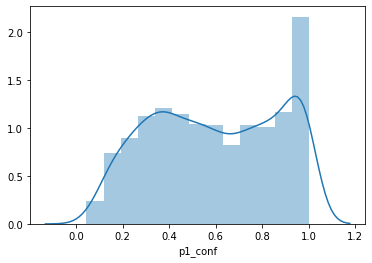

In [15]:
# Distribution of neural network confidence in breed predictions
sn.distplot(imagePredict.p1_conf)

`Notes` There is a large distribution of confidence percentages. The shape of the distribution is bimodal.

#### weRateDogs

In [16]:
weRateDogs.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2279,667405339315146752,NaN,NaN,2015-11-19 18:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Biden. Biden just tripped... 7/10 http...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667405339...,7,10,Biden,None,None,None,None
550,804738756058218496,NaN,NaN,2016-12-02 17:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Django. He accidentally opened the fro...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804738756...,12,10,Django,None,None,None,None
2092,670782429121134593,NaN,NaN,2015-11-29 01:52:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dude slaps your girl's ass what do you do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670782429...,5,10,None,None,None,None,None


In [17]:
weRateDogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [18]:
weRateDogs.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [19]:
weRateDogs.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

`Note` 666 seems like a strange rating to give your dog. Several of the denominators are also not out of ten.

In [20]:
tweetInfo.sample(3)

,created_at,id,id_str,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
1805,Mon Dec 14 01:58:31 +0000 2015,676219687039057920,676219687039057920,This is Kenneth. He's stuck in a bubble. 10/10...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 676219682148499456, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,75273,False,False,False,False,en,NaN,NaN,NaN,NaN
853,Thu Aug 04 15:48:47 +0000 2016,761227390836215808,761227390836215808,This is Albert. He just found out that bees ar...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 761227386398633985, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,5375,False,False,False,False,en,NaN,NaN,NaN,NaN
1267,Fri Mar 11 02:36:57 +0000 2016,708119489313951744,708119489313951744,This is Cooper. He basks in the glory of rebel...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 708119483462905857, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,2688,False,False,False,False,en,NaN,NaN,NaN,NaN


In [21]:
tweetInfo.isna().any()

created_at                       False
id                               False
id_str                           False
text                             False
truncated                        False
entities                         False
extended_entities                 True
source                           False
in_reply_to_status_id             True
in_reply_to_status_id_str         True
in_reply_to_user_id               True
in_reply_to_user_id_str           True
in_reply_to_screen_name           True
user                             False
geo                               True
coordinates                       True
place                             True
contributors                      True
is_quote_status                  False
retweet_count                    False
favorite_count                   False
favorited                        False
retweeted                        False
possibly_sensitive                True
possibly_sensitive_appealable     True
lang                     

In [22]:
tweetInfo.lang.value_counts()

en     2313
und       7
nl        3
in        3
tl        1
eu        1
et        1
ro        1
es        1
Name: lang, dtype: int64

Observations: 

`imagePredict`

- This DataFrame contains information on **dog breed predictions** for the photos uploaded onto WeRateDogs.
- Of the photos uploaded, some do not have a dog as the subject.
- There are several low-confidence predictions.

`weRateDogs`

- This DataFrame contains information on **tweet text contents**, as well as others that we will ignore for the sake of our analysis. 
- In the text of several tweets, users refer to their dogs as doggo, floofer, etc. These dog "stages" are separated into different columns, but they are essentially the same type.
- There are several columns that are unnecessary for analysis, such as: source, expanded_urls, and retweeted_status_timestamp.
- There were some tweetIDs listed in our weRateDogs DataFrame that were unavailable (due to deletion) from the twitter API page. 
- There seems to be an issue with the dog ratings, where the numerators and denominators are either strange numbers (that we wouldn't expect users to type) or extraordinarily large.

    
`tweetInfo`

- This DataFrame contains information on **how people interacted with the tweet** such as: 
    - Retweets (when users take another user's tweet and tweet it out themselves)
    - Replies (when users use the tweet in a reply)
    - Favourites 
- There are several columns that are unnecessary for analysis, such as: id, source, and possibly_sensitive_appealable (whatever that means). There are also a few columns that are completely empty.
- But there are also several potentially interesting columns, such as retweet count and favorite count.

<a id='clean'></a>
## Clean

First, we'll create copies of our DataFrames. That way, we can refer to the original DataFrames when testing our code or making adjustments.

In [93]:
weRateDogs_clean = weRateDogs.copy()
imagePredict_clean = imagePredict.copy()
tweetInfo_clean = tweetInfo.copy()

We can split our cleaning tasks into tidying and quality issues. 

`Tidying Tasks`

1. Creating a single dog_stage column 
2. Removing retweets
3. Removing tweet duplicates that are not retweets in the `weRateDogs` DataFrame

`Quality Tasks`

1. Changing data to their appropriate type
2. Renaming columns so that columns among the dataframes that contain the same information match in label
3. Renaming columns so that labels are more intuitive
4. Fixing user ratings in the `weRateDogs` DataFrame
5. Filtering out non-dog names in the `weRateDogs` DataFrame
6. Removing non-dog photos from the `imagePredict` DataFrame
7. Dealing with low-confidence breed predictions in `imagePredict`
8. Filtering out unnecessary columns from each DataFrame
9. Merging all the DataFrames

<a id="changeandRename"> </a>
## Define

**Save** data to appropriate type and **rename** matching columns:

`weRateDogs`
- tweet_id to str
- timestamp to Pandas datetime
- rating_numerator to float
- \*dog stage to category (will do later)

`tweetInfo`
- rename 'id_str' to 'tweet_id'
- rename 'lang' to 'language'
- language to categorical

`imagePredict`
- rename 'p1' to 'breed'
- rename 'p1_conf' to 'confidence'
- rename 'p1_dog' to 'dog_photo'
- tweet_id to str
- breed to string

## Code

In [94]:
weRateDogs_clean.tweet_id = weRateDogs_clean.tweet_id.astype(str)
weRateDogs_clean.timestamp = pd.to_datetime(weRateDogs_clean.timestamp)
weRateDogs_clean.rating_numerator = weRateDogs_clean.rating_numerator.astype(float)
tweetInfo_clean.rename({'id_str': 'tweet_id', 'lang': 'language'}, axis = 1, inplace = True)
tweetInfo_clean.language = tweetInfo_clean.language.astype('category')

imagePredict_clean.rename({'p1': 'breed', 'p1_conf': 'confidence', 'p1_dog': 'dog_photo'}, axis = 1, inplace = True)
imagePredict_clean.tweet_id = imagePredict_clean.tweet_id.astype(str)
imagePredict_clean.breed = imagePredict_clean.breed.astype(str)

## Test

In [95]:
weRateDogs_clean[['tweet_id', 'timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 2 columns):
tweet_id     2356 non-null object
timestamp    2356 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 36.9+ KB


In [96]:
tweetInfo_clean[['tweet_id', 'language']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 2 columns):
tweet_id    2331 non-null object
language    2331 non-null category
dtypes: category(1), object(1)
memory usage: 21.0+ KB


In [97]:
imagePredict_clean[['tweet_id', 'breed', 'confidence', 'dog_photo']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id      2075 non-null object
breed         2075 non-null object
confidence    2075 non-null float64
dog_photo     2075 non-null bool
dtypes: bool(1), float64(1), object(2)
memory usage: 50.8+ KB


`Dog stages are spread out among four columns`

<a id='ratingsScandal'></a>
## Define

- Fix user ratings
- Convert rating_numerator to float

## Code

In [98]:
# Find text with floats
weRateDogs[weRateDogs.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

/Users/adrienneterrado/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,5
340,"RT @dog_rates: This is Logan, the Chow who liv...",75
695,"This is Logan, the Chow who lived. He solemnly...",75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27
1689,I've been told there's a slight possibility he...,5
1712,Here we have uncovered an entire battalion of ...,26


Let's look a little closer at the first tweet.

In [99]:
weRateDogs[weRateDogs.text.str.contains(r"(\d+\.\d*\/\d+)")][['text']].iloc[0].text

/Users/adrienneterrado/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'

`Note` The user rated her dog Bella a 13.5/10, but the rating numerator was extracted as 5. 

```
```

In [100]:
# Convert rating_numerator type from int to float
weRateDogs_clean.rating_numerator = weRateDogs_clean.rating_numerator.astype(float)

In [101]:
# Get the correct rating values
tmp = weRateDogs.text.str.extract(r"(\d+\.\d*\/\d+)").dropna()
tmp

,0
45,13.5/10
340,9.75/10
695,9.75/10
763,11.27/10
1689,9.5/10
1712,11.26/10


In [102]:
# Replace the incorrect values
weRateDogs_clean.loc[tmp.index, 'rating_numerator'] = tmp[0].str.extract(r"(\d+\.\d*)")[0]

In [205]:
weRateDogs_clean.rating_numerator = weRateDogs_clean.rating_numerator.astype(float)

## Test

In [103]:
weRateDogs_clean[weRateDogs_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

/Users/adrienneterrado/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator
45,This is Bella. She hopes her smile made you sm...,13.5
340,"RT @dog_rates: This is Logan, the Chow who liv...",9.75
695,"This is Logan, the Chow who lived. He solemnly...",9.75
763,This is Sophie. She's a Jubilant Bush Pupper. ...,11.27
1689,I've been told there's a slight possibility he...,9.5
1712,Here we have uncovered an entire battalion of ...,11.26


In [206]:
weRateDogs_clean.dtypes

tweet_id                           object
text                               object
timestamp             datetime64[ns, UTC]
name                               object
dog_stage                        category
rating_numerator                  float64
rating_denominator                  int64
dtype: object

<a id='dogStage'></a>
## Define

Create a single 'dog stage' column in our `weRateDogs` DataFrame.

## Code

In [104]:
doggoCol = weRateDogs_clean[weRateDogs_clean.doggo == 'doggo'][['tweet_id', 'doggo']]
doggoCol.columns = ['tweet_id', 'dog_stage']
doggoCol

,tweet_id,dog_stage
9,890240255349198849,doggo
43,884162670584377345,doggo
99,872967104147763200,doggo
108,871515927908634625,doggo
110,871102520638267392,doggo
...,...,...
1117,732375214819057664,doggo
1141,727644517743104000,doggo
1156,724771698126512129,doggo
1176,719991154352222208,doggo


In [105]:
# Do the same for the other dog stages
pupperCol = weRateDogs_clean[weRateDogs_clean.pupper == 'pupper'][['tweet_id', 'pupper']]
pupperCol.columns = ['tweet_id', 'dog_stage']
flooferCol = weRateDogs_clean[weRateDogs_clean.floofer == 'floofer'][['tweet_id', 'floofer']]
flooferCol.columns = ['tweet_id', 'dog_stage']
puppoCol = weRateDogs_clean[weRateDogs_clean.puppo == 'puppo'][['tweet_id', 'puppo']]
puppoCol.columns = ['tweet_id', 'dog_stage']

dogStages = pd.concat([doggoCol, pupperCol, flooferCol, puppoCol])

In [106]:
weRateDogs_clean = weRateDogs_clean.merge(dogStages, on='tweet_id', how='left')

In [107]:
weRateDogs_clean.dog_stage = weRateDogs_clean.dog_stage.astype('category')

#### \*Note

I couldn't figure out how to use the .melt function to work for this task

## Test

In [108]:
# Check if tweet IDs in dogStages are present in the main DataFrame before joining
dogStages.tweet_id.isin(weRateDogs_clean.tweet_id)

9       True
43      True
99      True
108     True
110     True
        ... 
947     True
961     True
1035    True
1048    True
1083    True
Name: tweet_id, Length: 394, dtype: bool

In [109]:
weRateDogs_clean.dog_stage.value_counts()

pupper     257
doggo       97
puppo       30
floofer     10
Name: dog_stage, dtype: int64

In [110]:
# But we have duplicates
weRateDogs_clean[weRateDogs_clean.tweet_id.duplicated()].sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
1076,741067306818797568,NaN,NaN,2016-06-10 00:39:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None,pupper
581,801115127852503040,NaN,NaN,2016-11-22 17:28:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None,pupper
192,855851453814013952,NaN,NaN,2017-04-22 18:31:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo,puppo


## Define

Remove tweet duplicates in the `weRateDogs.`

## Code

In [111]:
# Pull the duplicated tweet_ids
dupesList = list(weRateDogs_clean[weRateDogs_clean.tweet_id.duplicated()]['tweet_id'])
dupesList[13]

'733109485275860992'

In [112]:
test = weRateDogs_clean.copy()

In [113]:
# Look for reason that one of the IDs is duplicated
test[test.tweet_id == '733109485275860992']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
1126,733109485275860992,NaN,NaN,2016-05-19 01:38:16+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Like father (doggo), like son (pupper). Both 1...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None,doggo
1127,733109485275860992,NaN,NaN,2016-05-19 01:38:16+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Like father (doggo), like son (pupper). Both 1...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo,None,pupper,None,pupper


So it looks like these observations were duplicated because **there were two dog_stage values for a single tweet.** You can see how this happened by looking at the 'text' column. 

In [114]:
# Find the ids for the duplicates
ids = test[test.tweet_id.isin(dupesList)].tweet_id

# Change dog_stage type to string in order to replace duplicates with 'multiple'
test.dog_stage = test.dog_stage.astype(str)

# Replace dog_stage values with multiple
test.loc[test.tweet_id.isin(ids), 'dog_stage'] = 'multiple'

In [115]:
test.drop_duplicates(inplace=True)

## Test

In [116]:
test.dog_stage.value_counts()

nan         1976
pupper       245
doggo         83
puppo         29
multiple      14
floofer        9
Name: dog_stage, dtype: int64

In [117]:
test.dog_stage = test.dog_stage.astype('category')

In [118]:
weRateDogs_clean = test

## Define

Replace non-names with 'None' in our dog names column. 

## Code

Names that are added incorrectly by the algorithm can be filtered out by calling which names are **all lowercase.**

In [119]:
nameFilter = list(weRateDogs[weRateDogs.name.str.islower()].name)
pd.Series(nameFilter).unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [120]:
# Create dictionary
{k:'None' for k in nameFilter}

{'such': 'None',
 'a': 'None',
 'quite': 'None',
 'not': 'None',
 'one': 'None',
 'incredibly': 'None',
 'mad': 'None',
 'an': 'None',
 'very': 'None',
 'just': 'None',
 'my': 'None',
 'his': 'None',
 'actually': 'None',
 'getting': 'None',
 'this': 'None',
 'unacceptable': 'None',
 'all': 'None',
 'old': 'None',
 'infuriating': 'None',
 'the': 'None',
 'by': 'None',
 'officially': 'None',
 'life': 'None',
 'light': 'None',
 'space': 'None'}

In [121]:
weRateDogs_clean.replace({k:None for k in nameFilter}, inplace=True)

## Test

In [122]:
weRateDogs_clean.name.str.contains('Charlie').sum()

12

In [123]:
weRateDogs_clean.name.str.contains('incredibly').sum()

0

<a id='retweets'></a>
## Define

Remove retweets from tweetInfo DataFrame.

## Code

I think we can filter retweets by finding observations where `there are values for the retweeted_status column.`

In [124]:
dropTest = tweetInfo_clean[tweetInfo_clean.retweeted_status.isna() == False]
dropTest.sample(2)

,created_at,id,tweet_id,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,language,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
460,Mon Jan 02 20:12:21 +0000 2017,816014286006976512,816014286006976512,RT @dog_rates: This is Larry. He has no self c...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 732005607704649728, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,0,False,False,False,False,en,{'created_at': 'Mon May 16 00:31:53 +0000 2016...,NaN,NaN,NaN
327,Thu Feb 16 13:11:05 +0000 2017,832215726631055365,832215726631055365,RT @dog_rates: This is Moreton. He's the Good ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 793286466235408384, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,0,False,False,False,False,en,{'created_at': 'Tue Nov 01 03:00:09 +0000 2016...,NaN,NaN,NaN


Looking at the text column, find the dog name associated with the tweet and pull the tweets from our `weRateDogs` DataFrame that include that name. In my case, it's `'Gidget'`. 

In [125]:
weRateDogs_clean[weRateDogs_clean.name == 'Gidget'][['tweet_id', 'text']]

,tweet_id,text
224,849668094696017920,RT @dog_rates: This is Gidget. She's a spy pup...
332,833124694597443584,This is Gidget. She's a spy pupper. Stealthy a...


It's a retweet!! Here's another:

In [126]:
weRateDogs_clean[weRateDogs_clean.name == 'Shadow'][['tweet_id', 'text']]

,tweet_id,text
73,878404777348136964,RT @dog_rates: Meet Shadow. In an attempt to r...
75,878281511006478336,Meet Shadow. In an attempt to reach maximum zo...
599,798925684722855936,This is Shadow. He's a firm believer that they...
1330,706644897839910912,Meet Shadow. She's tired of the responsibiliti...


In [127]:
retweetIDs = list(dropTest.tweet_id)

In [128]:
retweets = tweetInfo_clean[tweetInfo_clean.tweet_id.isin(retweetIDs)].index

In [129]:
tweetInfo_clean.drop(retweets, axis=0, inplace=True)

### Test

In [130]:
tweetInfo.shape[0]

2331

In [131]:
tweetInfo_clean.shape[0]

2168

*Not the best check, but hey.

<a id='filterColumns'></a>
### Define

Choose the appropriate columns to retain for each of our DataFrames.

### Code

In [132]:
weRateDogs_clean = weRateDogs_clean[['tweet_id', 'text', 'timestamp', 'name', 'dog_stage', 'rating_numerator',
                               'rating_denominator']]
weRateDogs_clean.sample(3)

,tweet_id,text,timestamp,name,dog_stage,rating_numerator,rating_denominator
362,829861396166877184,This is Mia. She already knows she's a good do...,2017-02-10 01:15:49+00:00,Mia,nan,12,10
1881,675334060156301312,Good morning here's a grass pupper. 12/10 http...,2015-12-11 15:19:21+00:00,None,pupper,12,10
901,759566828574212096,RT @dog_rates: This... is a Tyrannosaurus rex....,2016-07-31 01:50:18+00:00,None,nan,10,10


`Reasoning for retaining my chosen columns:`

- For all the DataFrames, tweet_id is kept in order to effectively merge the DataFrames together. 
- The other columns either held redundant information or would not be interesting enough for analysis.

In [133]:
tweetInfo_clean = tweetInfo_clean[['tweet_id', 'retweet_count', 'favorite_count']]
tweetInfo_clean.sample(3)

,tweet_id,retweet_count,favorite_count
942,750383411068534784,1156,4595
1047,740214038584557568,1966,6701
959,749395845976588288,3460,8630


`Reasoning for retaining my chosen columns:`

- A lot of the other columns would have been interesting (such as the ones on location), but they:
    - Are mostly empty
    - A completely empty
    - Contain essentially all the same values (English in the language column)
- Other columns, such as favorited, are marked True if the user likes their own photo. Surprisingly, no one is that egotistical, so all values for that column are False. 

In [134]:
imagePredict_clean = imagePredict_clean[['tweet_id', 'breed', 'confidence', 'dog_photo', 'jpg_url']]
imagePredict_clean.sample(3)

,tweet_id,breed,confidence,dog_photo,jpg_url
791,690690673629138944,bath_towel,0.194532,False,https://pbs.twimg.com/media/CZXTgKkWwAA5UZJ.jpg
1103,721503162398597120,Pomeranian,0.997750,True,https://pbs.twimg.com/media/CgNLS1PW8AAxWSN.jpg
1101,720785406564900865,Chihuahua,0.896422,True,https://pbs.twimg.com/media/CgC-gMCWcAAawUE.jpg


`Reasoning for retaining my chosen columns:`

- I only want to use the image's breed for analysis if the algorithm is relatively confident about its prediction. The algorithm is most confident about the first photo listed, so I discarded Photo 2 and 3 data. 
- The confidence and dog_photo columns are kept to query photos that are
    1. in fact dogs
    2. predicted to a relatively high degree of confidence
- Keeping jpg_url will make it easier to check if I query correctly in later cleaning stages

<a id='merge'></a>
## Define

Combine the weRateDogs, tweetInfo, and imagePredict DataFrames into a single DataFrame. 
- Merge onto the tweetInfo DataFrame because the weRateDogs and imagePredict DataFrames may contain information for tweets that have been deleted

## Code

In [135]:
# Merge weRateDogs onto tweetInfo
test = tweetInfo_clean.merge(weRateDogs_clean, on = 'tweet_id')

## Test

In [136]:
tweetInfo_clean.sample(1)

,tweet_id,retweet_count,favorite_count
372,826598365270007810,2380,10182


In [137]:
# The maximum amount of observations we should have
tweetInfo_clean.shape[0]

2168

In [138]:
weRateDogs_clean.sample(1)

,tweet_id,text,timestamp,name,dog_stage,rating_numerator,rating_denominator
941,754449512966619136,This is Dex. He can see into your past and fut...,2016-07-16 22:55:55+00:00,Dex,nan,11,10


In [139]:
weRateDogs.shape[0]

2356

In [140]:
test.sample(1)

,tweet_id,retweet_count,favorite_count,text,timestamp,name,dog_stage,rating_numerator,rating_denominator
630,774639387460112384,1758,6860,This is Sprinkles. He's trapped in light jail....,2016-09-10 16:03:16+00:00,Sprinkles,nan,10,10


In [141]:
test.shape[0]

2168

## Code

In [143]:
# Merge our newly merged weRateDogs and tweetInfo DataFrame (test) onto imagePredict
test2 = test.merge(imagePredict_clean, on='tweet_id')

## Test

In [144]:
test2.sample()

,tweet_id,retweet_count,favorite_count,text,timestamp,name,dog_stage,rating_numerator,rating_denominator,breed,confidence,dog_photo,jpg_url
1854,668484198282485761,225,411,Good teamwork between these dogs. One is on lo...,2015-11-22 17:40:27+00:00,None,nan,9,10,standard_poodle,0.587372,True,https://pbs.twimg.com/media/CUbu1GAWsAEH3E-.jpg


In [145]:
test2.shape[0]

1987

In [146]:
imagePredict_clean.shape[0]

2075

In [147]:
df = test2

<a id='notDog'></a>
## Define

Remove photos where the subject is anything other than a dog

## Code

In [79]:
df.dog_photo.value_counts()

True     1470
False     517
Name: dog_photo, dtype: int64

In [80]:
df[df.dog_photo == False].sample(5)

,tweet_id,retweet_count,favorite_count,text,timestamp,name,dog_stage,rating_numerator,rating_denominator,breed,confidence,dog_photo,jpg_url
410,803380650405482500,1916,7970,Meet Sonny. He's an in-home movie critic. That...,2016-11-28 23:30:47+00:00,Sonny,nan,12,10,bookcase,0.890601,False,https://pbs.twimg.com/media/CyYub2kWEAEYdaq.jpg
1275,685532292383666176,1159,3030,"For the last time, WE. DO. NOT. RATE. BULBASAU...",2016-01-08 18:43:29+00:00,None,nan,9,10,white_wolf,0.318524,False,https://pbs.twimg.com/media/CYN_-6iW8AQhPu2.jpg
1389,679729593985699840,818,2164,This is Hunter. He was playing with his ball m...,2015-12-23 18:25:38+00:00,Hunter,nan,8,10,wallaby,0.164215,False,https://pbs.twimg.com/media/CW7iddWUsAElUC0.jpg
679,754747087846248448,527,2612,This is Keith. He's pursuing a more 2D lifesty...,2016-07-17 18:38:22+00:00,Keith,nan,12,10,rotisserie,0.471493,False,https://pbs.twimg.com/media/CnlmeL3WgAA4c84.jpg
1542,674664755118911488,245,894,This is Rodman. He's getting destroyed by the ...,2015-12-09 18:59:46+00:00,Rodman,nan,10,10,African_crocodile,0.330625,False,https://pbs.twimg.com/media/CVzkA7-WsAAcXz6.jpg


If you pull up the urls for any one of these, you'll quickly find that **the algorithm generated quite a few false negatives**. 

You'll also see a pattern that, when the algorithm predicts the photo to be of an animal other than a dog, it's often correct. However, when it predicts that the subject is an object, like a shopping cart, for instance, the photo is actually of a dog in a shopping cart. 

We could maybe get a little closer to filtering out non-dog images by removing observations in which:
- dog_photo is False 
- name is 'None'

In [81]:
# Take a sample of photos under these conditions
df[(df.dog_photo == False) & (df.name != 'None')].sample(1)

,tweet_id,retweet_count,favorite_count,text,timestamp,name,dog_stage,rating_numerator,rating_denominator,breed,confidence,dog_photo,jpg_url
479,790581949425475584,7363,21161,This is Duke. He sneaks into the fridge someti...,2016-10-24 15:53:19+00:00,Duke,nan,11,10,refrigerator,0.998886,False,https://pbs.twimg.com/media/Cvi2FiKWgAAif1u.jpg


Even after querying under additional conditions, it is still difficult to ensure that the files we pull are false negatives. 

Thus, we'll just drop all photos where dog_photo = False.

In [148]:
df = df[df.dog_photo == True]

## Test

In [149]:
df.dog_photo.value_counts()

True    1470
Name: dog_photo, dtype: int64

In [150]:
# Not technically a test, but I want to drop this column, and it wouldn't make sense to test value_counts on a column
# that doesn't exist
df.drop('dog_photo', axis=1, inplace=True)

/Users/adrienneterrado/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<a id='lowConf'></a>
#### \*Notes

The DataFrame still contains very low confidence breed predictions, but for the sake of retaining as much dog photo data as we can, `we'll keep those observations.` However, we should not include low-confidence predictions in any of our analyses that involve comparing dog breeds.

<a id='store'></a>
## Store DataFrame as a CSV file

In [85]:
df.to_csv('twitter_archive_master.csv', index=False)

In [86]:
pd.read_csv('twitter_archive_master.csv').sample(1)

,tweet_id,retweet_count,favorite_count,text,timestamp,name,dog_stage,rating_numerator,rating_denominator,breed,confidence,jpg_url
726,716080869887381504,1902,6731,Here's a super majestic doggo and a sunset 11/...,2016-04-02 01:52:38+00:00,None,doggo,11.0,10,golden_retriever,0.638625,https://pbs.twimg.com/media/CfAHv83UMAIEQYx.jpg


<a id='analysis'></a>
## Analysis

`Goals:`
- Plot retweet_count by favorite_count as a sanity check. Should be linear.
- Plot the relationship between dog ratings and retweet count
- See if the site had gotten more or less popular over the course of when the data was collected:
 - In terms of the number of tweets posted to the site
 - In terms of general traffic
- Observe relationship between dog breeds and popularity
- Observe relationship between dog stage and popularity

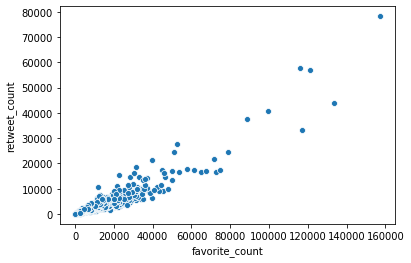

In [151]:
sn.scatterplot(data=df, x='favorite_count', y='retweet_count')

>Linear. Makes sense.

In [162]:
df.rating_numerator = df.rating_numerator.astype(float)

df['rating_prop'] = df.loc[:, 'rating_numerator'] / df.loc[:, 'rating_denominator']

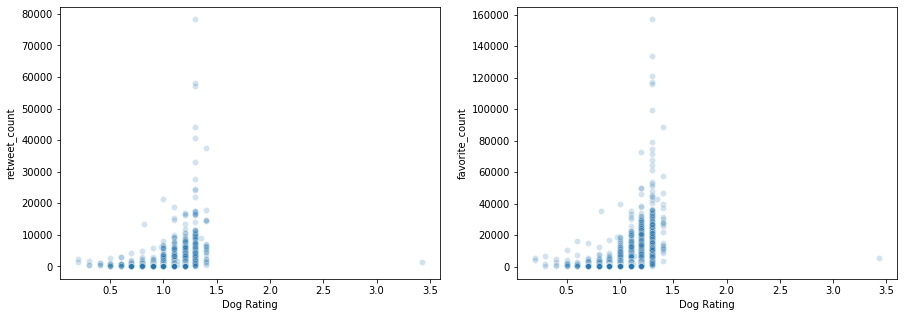

In [186]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
sn.scatterplot(data=df, x='rating_prop', y='retweet_count', ax=ax[0], alpha = 0.2)
sn.scatterplot(data=df, x='rating_prop', y='favorite_count', ax=ax[1], alpha = 0.2)
for i in (0,1):
    ax[i].set_xlabel("Dog Rating")

> Dog ratings were calculated by dividing rating numerators by their denominators. There is a positive correlation between dog ratings and both retweet and favourite counts. However, the general public did not share the same sentiment with that one user who rated their dog absurdly highly. 

In [214]:
# That tweet
df.sort_values('rating_prop', ascending = False).iloc[0]

tweet_id                                             810984652412424192
retweet_count                                                      1470
favorite_count                                                     5467
text                  Meet Sam. She smiles 24/7 &amp; secretly aspir...
timestamp                                     2016-12-19 23:06:23+00:00
name                                                                Sam
dog_stage                                                           nan
rating_numerator                                                     24
rating_denominator                                                    7
breed                                                  golden_retriever
confidence                                                     0.871342
jpg_url                 https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg
rating_prop                                                     3.42857
Name: 381, dtype: object

> Honestly, that photo isn't that great. 10/10 wouldn't retweet or favorite. 

/Users/adrienneterrado/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


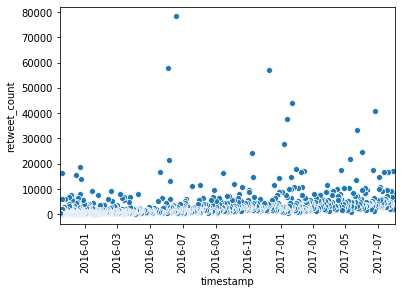

In [88]:
sn.scatterplot(data=df, x=df.timestamp.dt.date, y='retweet_count')
plt.xlim(xmin='2015-11-15', xmax='2017-08-01')
plt.xticks(rotation='vertical')
plt.show()

> Not too interesting. Let's try to find a different way to view this data

<a id='rttime'></a>
## WeRateDogs User Traffic

In [188]:
# The count function counts the number of observations associated with each index. In this case, 192 in the first row
# means that 192 users tweeted to WeRateDogs in November of 2015. 
tweetsPerMonth = df[['tweet_id']].groupby(by=[df.timestamp.dt.year, df.timestamp.dt.month]).count()
tweetsPerMonth.columns = ['number_of_tweets']
tweetsPerMonth

number_of_tweets
timestamp timestamp                  
2015      11                      192
          12                      245
2016      1                       127
          2                        84
          3                        92
          4                        45
          5                        40
          6                        61
          7                        67
          8                        44
          9                        49
          10                       49
          11                       44
          12                       46
2017      1                        52
          2                        51
          3                        35
          4                        31
          5                        33
          6                        38
          7                        44
          8                         1

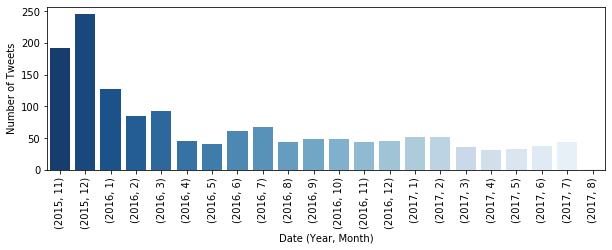

In [217]:
plt.figure(figsize=(10,3))
sn.barplot(x=tweetsPerMonth.index, y=tweetsPerMonth.number_of_tweets, palette = 'Blues_r')
plt.xticks(rotation='vertical')
plt.xlabel('Date (Year, Month)')
plt.ylabel('Number of Tweets')
plt.savefig('tweetsPerMonth.jpg', dpi = 1200, bbox_inches='tight')

>Based on the number of tweets to WeRateDogs, it appears that `WeRateDogs decreased in popularity` over the course of time when this data was collected.

In [190]:
# The sum function sums the values associated with each index. For instance, the 81918 column means that 81918 users
# retweeted posts from WeRateDogs in November of 2015.
retweetsPerMonth = df[['tweet_id', 'retweet_count']].groupby(by=[df.timestamp.dt.year, df.timestamp.dt.month]).sum()
retweetsPerMonth

retweet_count
timestamp timestamp               
2015      11                 81918
          12                285288
2016      1                 144221
          2                 110157
          3                 124025
          4                  64706
          5                  78485
          6                 271634
          7                 134697
          8                 121622
          9                 145551
          10                169982
          11                174769
          12                215698
2017      1                 293955
          2                 200697
          3                 154993
          4                 158177
          5                 202794
          6                 228374
          7                 269475
          8                   5730

In [191]:
tweetsPerMonth['retweet_count'] = retweetsPerMonth['retweet_count']
tweetsPerMonth['normalized_retweet_count'] = tweetsPerMonth['retweet_count'] / tweetsPerMonth['number_of_tweets']
tweetsPerMonth

number_of_tweets  retweet_count  normalized_retweet_count
timestamp timestamp                                                           
2015      11                      192          81918                426.656250
          12                      245         285288               1164.440816
2016      1                       127         144221               1135.598425
          2                        84         110157               1311.392857
          3                        92         124025               1348.097826
          4                        45          64706               1437.911111
          5                        40          78485               1962.125000
          6                        61         271634               4453.016393
          7                        67         134697               2010.402985
          8                        44         121622               2764.136364
          9                        49         145551               2970.428571
          10                       49         169982               3469.020408
          11                       44         174769               3972.022727
          12                       46         215698               4689.086957
2017      1                        52         293955               5652.980769
          2                        51         200697               3935.235294
          3                        35         154993               4428.371429
          4                        31         158177               5102.483871
          5                        33         202794               6145.272727
          6                        38         228374               6009.842105
          7                        44         269475               6124.431818
          8                         1           5730               5730.000000

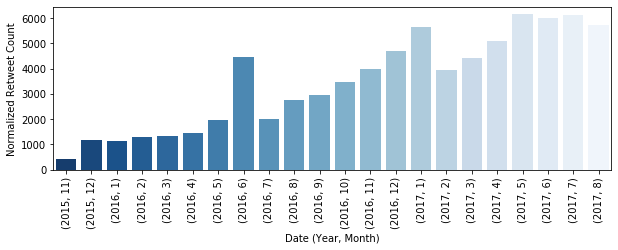

In [216]:
plt.figure(figsize=(10,3))
sn.barplot(x=tweetsPerMonth.index, y=tweetsPerMonth.normalized_retweet_count, palette = 'Blues_r')
plt.xticks(rotation='vertical')
plt.xlabel('Date (Year, Month)')
plt.ylabel('Normalized Retweet Count')
plt.savefig('retweetsPerMonth.jpg', dpi = 1200, bbox_inches='tight')

>Judging by retweets, it seems that the website actually gets `similar levels of traffic` (as measured by retweets) `per month` and even gets `more traffic per post`.

<a id='rtbreed'></a>
## Breed Popularity

In [193]:
tweetsPerDog = df[df.confidence > df.confidence.median()].groupby('breed')[['tweet_id']].count()
tweetsPerDog.columns = ['number_of_tweets']
tweetsPerDog

,number_of_tweets
breed,
Afghan_hound,1
Airedale,4
American_Staffordshire_terrier,5
Appenzeller,1
Bernese_mountain_dog,8
...,...
standard_poodle,1
toy_poodle,20
toy_terrier,1


In [194]:
retweetsPerDog = df[df.confidence > df.confidence.median()][['tweet_id', 'retweet_count']].groupby(by=[df[df.confidence > df.confidence.median()].breed]).sum()
retweetsPerDog

,retweet_count
breed,
Afghan_hound,4651
Airedale,3369
American_Staffordshire_terrier,10602
Appenzeller,675
Bernese_mountain_dog,9277
...,...
standard_poodle,1096
toy_poodle,42724
toy_terrier,2002


In [195]:
dogTrends = tweetsPerDog.merge(retweetsPerDog, on='breed')
dogTrends['retweet_count_normalized'] = dogTrends.retweet_count / dogTrends.number_of_tweets
# Only include breeds that are posted more than once. That should take care of any 'one hit wonders'
dogTrends = dogTrends[dogTrends.number_of_tweets >=2].sort_values('retweet_count_normalized', ascending=False).reset_index()
dogTrends

,breed,number_of_tweets,retweet_count,retweet_count_normalized
0,Cardigan,6,30227,5037.833333
1,Great_Pyrenees,9,42055,4672.777778
2,French_bulldog,21,95881,4565.761905
3,Labrador_retriever,55,245629,4465.981818
4,Chesapeake_Bay_retriever,9,34556,3839.555556
...,...,...,...,...
64,boxer,6,4103,683.833333
65,Lakeland_terrier,5,2842,568.400000
66,Irish_terrier,2,1062,531.000000
67,kuvasz,2,947,473.500000


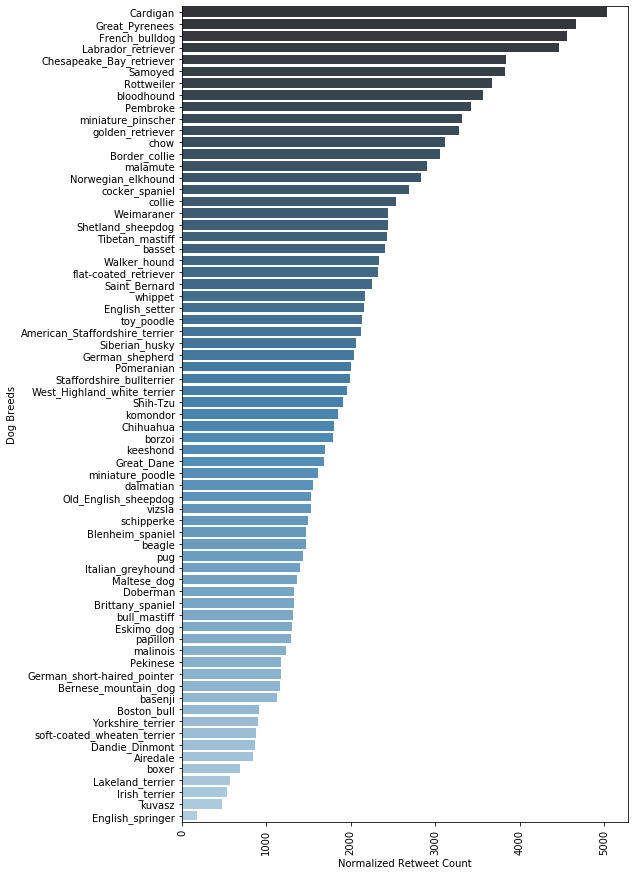

In [199]:
plt.figure(figsize=(8, 15))
sn.barplot(x=dogTrends.retweet_count_normalized, y=dogTrends.breed, palette = 'Blues_d')
plt.xlabel('Normalized Retweet Count')
plt.ylabel('Dog Breeds')
plt.savefig('retweetsPerBreed.jpg', dpi = 1200, bbox_inches='tight')

In [98]:
# The top ten most popular dog breeds by retweet count
# And no, Cardigan does not refer to that nice piece of clothing. It's basically a Corgi.
dogTrends[['breed', 'retweet_count_normalized']].loc[0:9]

,breed,retweet_count_normalized
0,Cardigan,5037.833333
1,Great_Pyrenees,4672.777778
2,French_bulldog,4565.761905
3,Labrador_retriever,4465.981818
4,Chesapeake_Bay_retriever,3839.555556
5,Samoyed,3832.400000
6,Rottweiler,3673.166667
7,bloodhound,3570.000000
8,Pembroke,3428.576271
9,miniature_pinscher,3323.857143


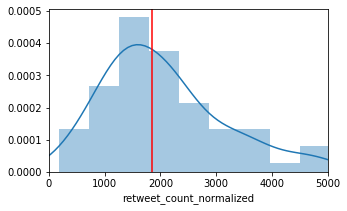

In [203]:
# Distribution of retweet counts per dog
plt.figure(figsize=(5,3))
sn.distplot(dogTrends[dogTrends.number_of_tweets >=2]['retweet_count_normalized'])
plt.axvline(dogTrends[dogTrends.number_of_tweets >=2]['retweet_count_normalized'].median(), color = 'r')
plt.xlim(0, 5000)
plt.savefig('breedRetweetDistribution.jpg', dpi = 1200)

## Retweets by Dog Stage

In [100]:
# The raw number of retweets per dog stage
retweetsByStage = pd.DataFrame(df.groupby('dog_stage')['retweet_count'].sum())

# The number of tweets per dog stage
tweetsByStage = pd.DataFrame(df.groupby('dog_stage')['tweet_id'].count())
tweetsByStage.columns = ['number_of_tweets']
tweetsByStage['retweet_count'] = retweetsByStage.retweet_count

# The number of retweets per dog stage normalized by the number of tweets
tweetsByStage['retweet_count_normalized'] = tweetsByStage['retweet_count'] / tweetsByStage['number_of_tweets']
tweetsByStage[['retweet_count_normalized']]

,retweet_count_normalized
dog_stage,
doggo,7076.361702
floofer,4376.142857
multiple,5207.500000
nan,2237.032180
pupper,2277.569444
puppo,5950.000000


```
```